#1. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
import pickle

In [ ]:
def bp(y, fs=40/100, lowcut=.05, highcut=.1, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)

def get_mov_rms(y, fs=40/100, window=150):
    return np.sqrt(signal.convolve(y**2, np.ones(int(fs*window))/int(fs*window), mode='same'))

def get_mov_mean(y, fs=40/100, window=150):
    return signal.convolve(y, np.ones(int(fs*window))/int(fs*window), mode='same')

#2. Create Test dataset from unlabeled files

In [ ]:
df_notlabeled_files = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/df_notlabeled_files.csv')
df_notlabeled_files

,file_path,length_signal_second
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,880.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.8
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,3260.8
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.8
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2972.8
...,...,...
380,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.6
381,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2672.0
382,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.6
383,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,556.8


In [ ]:
def cut_signal_from_files(file_path, window_size, overlap_size, format=np.int32):
    """
    Cut a signal file into smaller segments with a specified window size and overlap.

    Args:
        file_path (str): Path to the signal file.
        window_size (int): Size of each segment.
        overlap_size (int): Number of samples to overlap between segments.
        format (dtype): Data type of the signal (e.g., np.float32).

    Returns:
        list: A list of smaller signal segments.
    """
    try:
        signal = np.fromfile(file_path, dtype=format)
        segments = []
        start_index = 0
        while start_index + window_size <= len(signal):
            segment = signal[start_index:start_index + window_size]
            segments.append(segment)
            start_index += window_size - overlap_size
        return segments
    except FileNotFoundError:
        return []

In [ ]:
# cut signal in 30m
cutted_signals = [None] * len(df_notlabeled_files)

for i in tqdm(range(len(df_notlabeled_files))):
  cutted_signals[i] = cut_signal_from_files(file_path=df_notlabeled_files['file_path'][i], window_size=30*60*40, overlap_size=0)
#7m14

100%|██████████| 385/385 [03:04<00:00,  2.09it/s]


In [ ]:
# convert cutted_signals to 1d array
unlabeled_1800s_signals = np.array([signal for sublist in cutted_signals for signal in sublist])

In [ ]:
len(unlabeled_1800s_signals)
#2942

2942

In [ ]:
len(unlabeled_1800s_signals[0])
#72000

72000

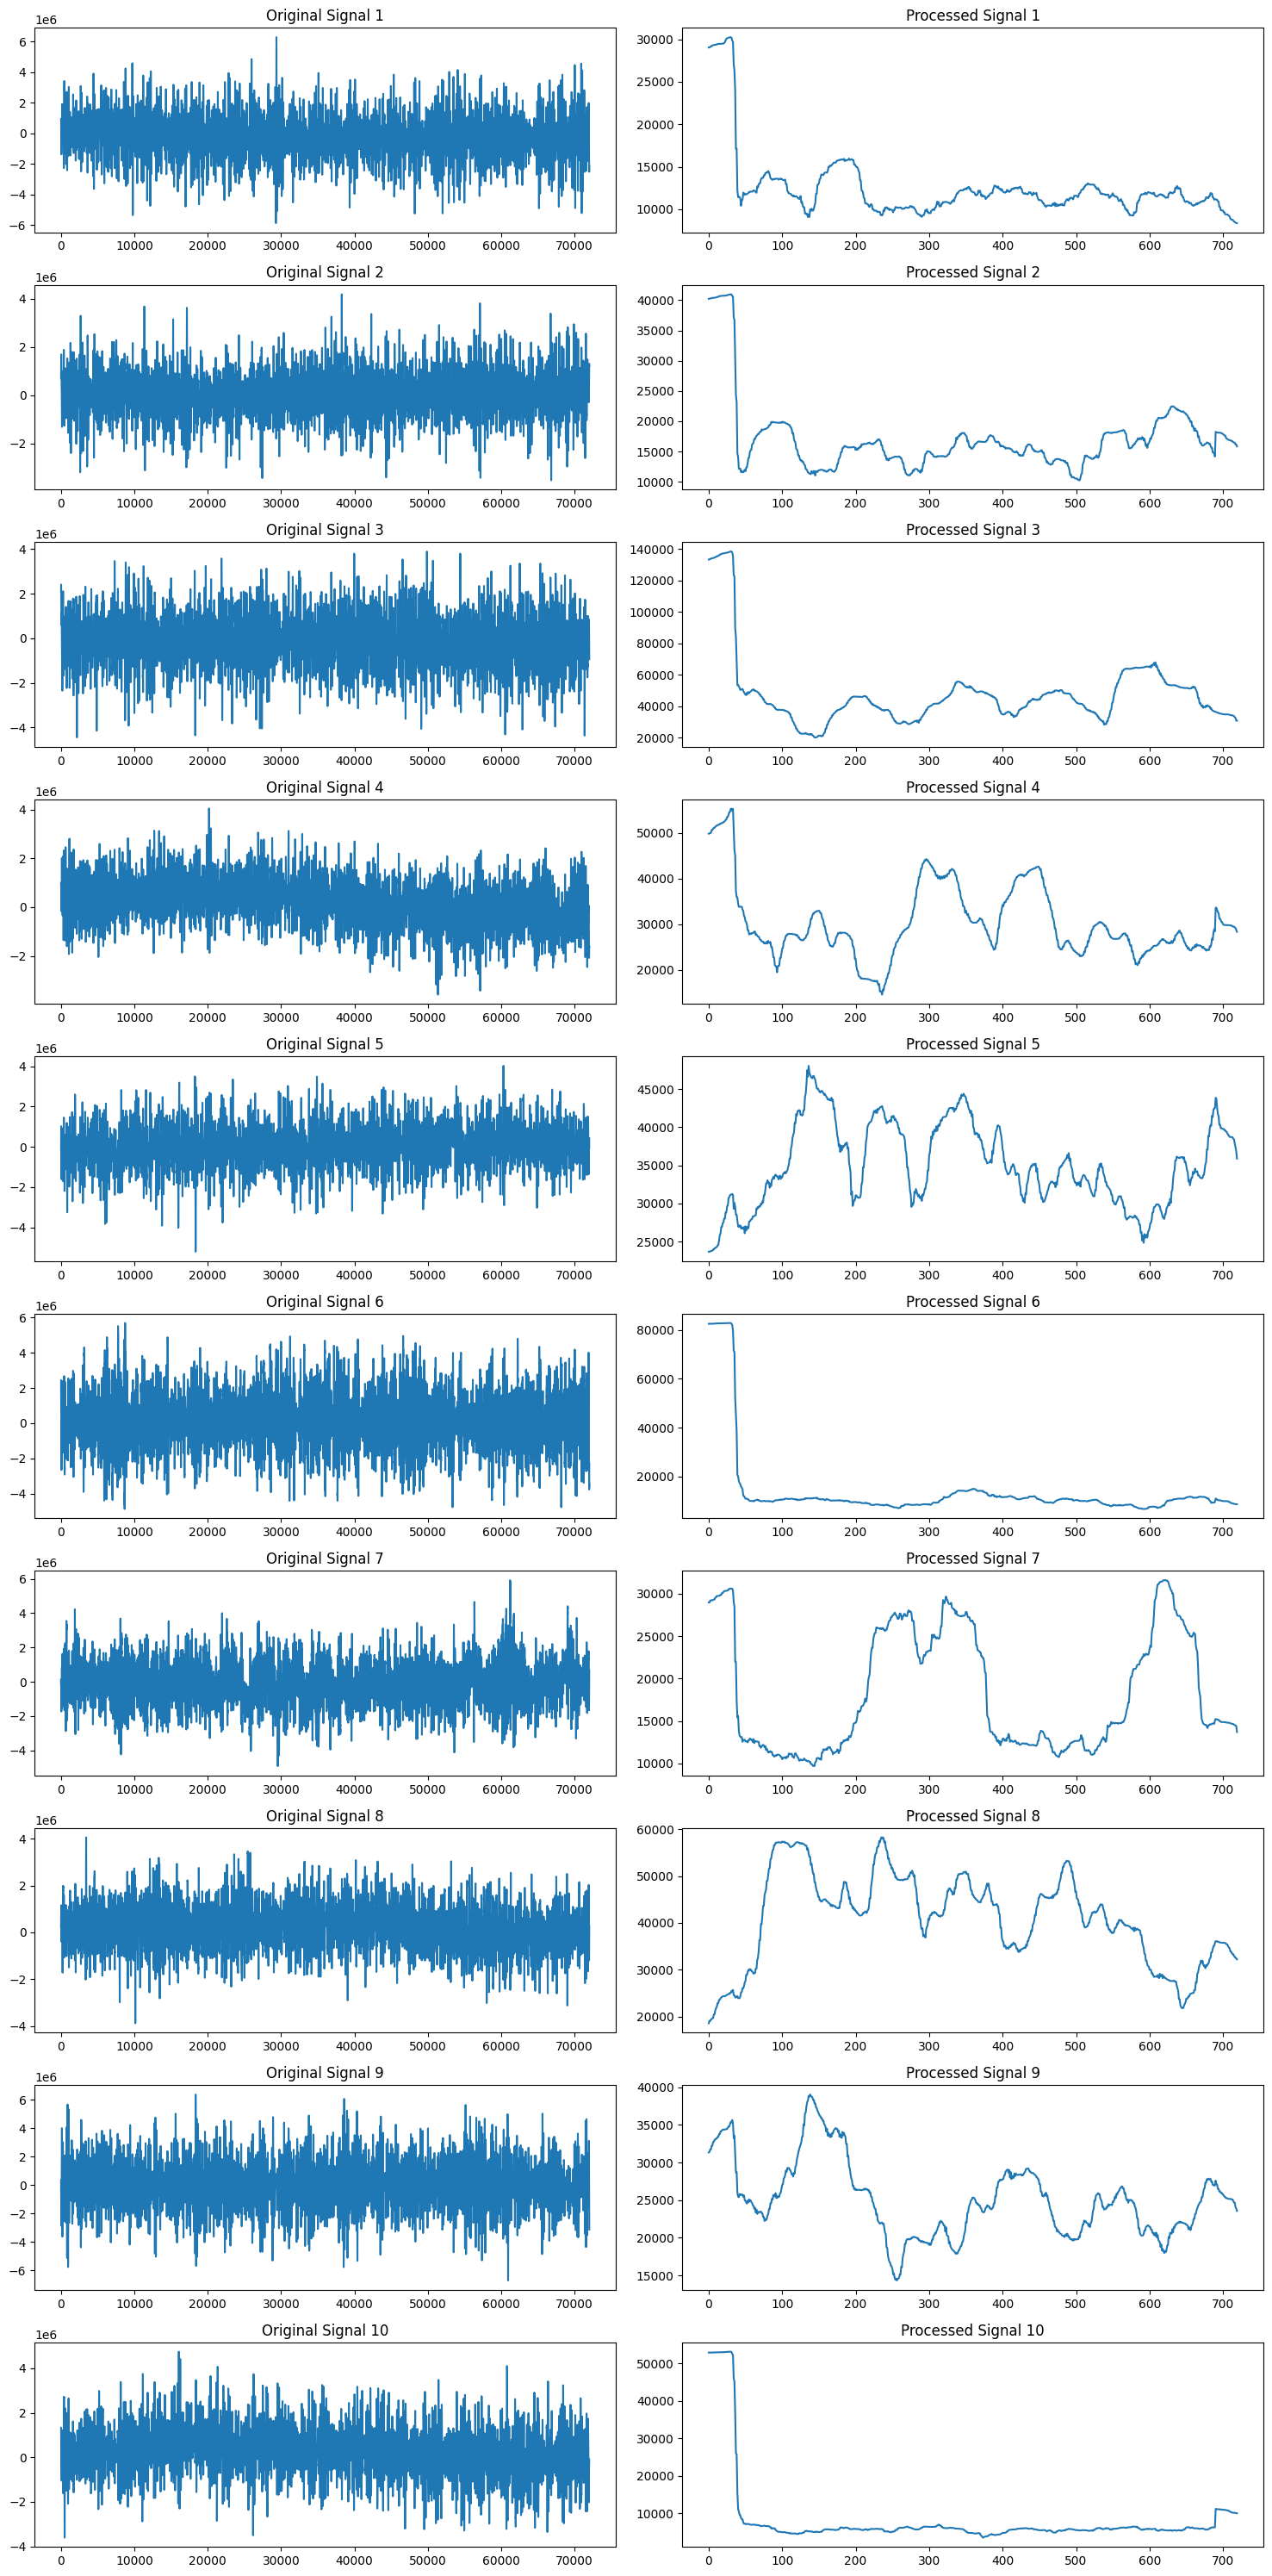

In [ ]:
# plot randomly 10 signal from unlabeled_1800s_signals in left column of figure and plot that signals applied bp, get_mov_rms, decimate 100 in right column of figure

from scipy import signal
import random

# Assuming unlabeled_120s_signals is already defined

random_indices = random.sample(range(len(unlabeled_1800s_signals)), 10)

fig, axes = plt.subplots(10, 2, figsize=(15, 30))

for i, index in enumerate(random_indices):
    y = unlabeled_1800s_signals[index]

    axes[i, 0].plot(y)
    axes[i, 0].set_title(f'Original Signal {i+1}')

    processed_signal = np.array(list(get_mov_rms(bp(signal.decimate(y, 100)))))


    axes[i, 1].plot(processed_signal)
    axes[i, 1].set_title(f'Processed Signal {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
# save unlabeled_1800s_signals

with open('/content/drive/MyDrive/MERMAIDAI/data/unlabeled_1800s_signals.pkl', 'wb') as f:
    pickle.dump(unlabeled_1800s_signals, f)

#3. Create Training dataset from labeled files

In [ ]:
df_labeled_earthquakes = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/data/procced_df_labeled_earthquake.csv')
df_labeled_earthquakes

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal_second,diff_end
0,1,2018-11-18 20:32:00.000,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-18 01:22:16,68984.0,69161.0,177.0
1,2,2018-11-30 17:42:00.000,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-30 07:31:32,36628.0,36806.0,178.0
2,3,2018-12-05 04:26:35.000,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-02 02:26:15,55397.5,55668.5,271.0
3,4,2018-12-11 02:38:40.000,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-07 20:15:43,282177.0,282412.0,235.0
4,5,2018-12-23 23:14:45.000,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-23 20:19:50,10495.0,10681.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,2019-08-02 01:26:00.000,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.04,5.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-01 22:59:47,8773.0,17158.0,65060.0
209,210,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.00,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,99378.0,113312.0
210,211,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.00,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,8460.0,21650.0,96392.0
211,212,2019-08-07 05:41:40.000,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.30,5.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,13190.0,83202.0,70012.0


In [ ]:
def get_signal_from_files(file_path, diff_start, after_arrival=40*60*60, window_size=40*60*30, overlap_size=0, step=40*60):
  """
  """

  y = np.fromfile(file_path, dtype=np.int32)
  y_negative = y[:int(diff_start*40 - window_size)]
  if len(y) - diff_start*40 < after_arrival:
    y_positive = y[int(diff_start*40 - window_size):-1]
  else:
    y_positive = y[int(diff_start*40 - window_size):int(diff_start*40 + after_arrival)]



  # Get posivite
  positive_segments = []
  start_index = step
  while start_index + window_size <= len(y_positive):
    segment = y_positive[start_index:start_index + window_size]
    positive_segments.append(segment)
    start_index += step

  # Get negative
  negative_segments = []
  start_index = step
  if len(y_negative) > window_size + step:
    while (start_index + window_size <= len(y_negative)) and (len(negative_segments) <= len(positive_segments)):
      segment = y_negative[start_index:start_index + window_size]
      negative_segments.append(segment)
      start_index += step

  return positive_segments, negative_segments

In [1]:
positive_signals = [None] * len(df_labeled_earthquakes)
negative_signals = [None] * len(df_labeled_earthquakes)
num_positive_signals = [None] * len(df_labeled_earthquakes)
num_negative_signals = [None] * len(df_labeled_earthquakes)
for i in tqdm(range(len(df_labeled_earthquakes))):
  file_path = df_labeled_earthquakes['file'][i]
  diff_start = df_labeled_earthquakes['diff_start'][i]
  positive_signals[i], negative_signals[i] = get_signal_from_files(file_path, diff_start)
  num_positive_signals[i] = len(positive_signals[i])
  num_negative_signals[i] = len(negative_signals[i])

NameError: name 'df_labeled_earthquakes' is not defined

In [ ]:
# add num_cutted_signals to df_labeled_earthquake as a column

df_labeled_earthquakes['num_positive_signals'] = num_positive_signals
df_labeled_earthquakes['num_negative_signals'] = num_negative_signals

In [ ]:
df_labeled_earthquakes.to_csv('/content/drive/MyDrive/MERMAIDAI/data/df_labeled_earthquake_updated.csv', index=False)

In [ ]:
# sum of num_cutted_signals

sum_num_positive_signals = df_labeled_earthquakes['num_positive_signals'].sum()
print(f"Sum of num_positive_signals: {sum_num_positive_signals}")
sum_num_negative_signals = df_labeled_earthquakes['num_negative_signals'].sum()
print(f"Sum of num_negative_signals: {sum_num_negative_signals}")

Sum of num_positive_signals: 11224
Sum of num_negative_signals: 10394


In [2]:
positive_1800s_signals = np.array([signal for sublist in positive_signals for signal in sublist])

with open('positive_1800s_signals.pickle', 'wb') as f:
    pickle.dump(positive_1800s_signals, f)

NameError: name 'np' is not defined

In [ ]:
!ls -lh positive_1800s_signals.pickle

-rw-r--r-- 1 root root 3.1G Nov  4 11:10 positive_1800s_signals.pickle


In [ ]:
negative_1800s_signals = np.array([signal for sublist in negative_signals for signal in sublist])

with open('negative_1800s_signals.pickle', 'wb') as f:
    pickle.dump(negative_1800s_signals, f)

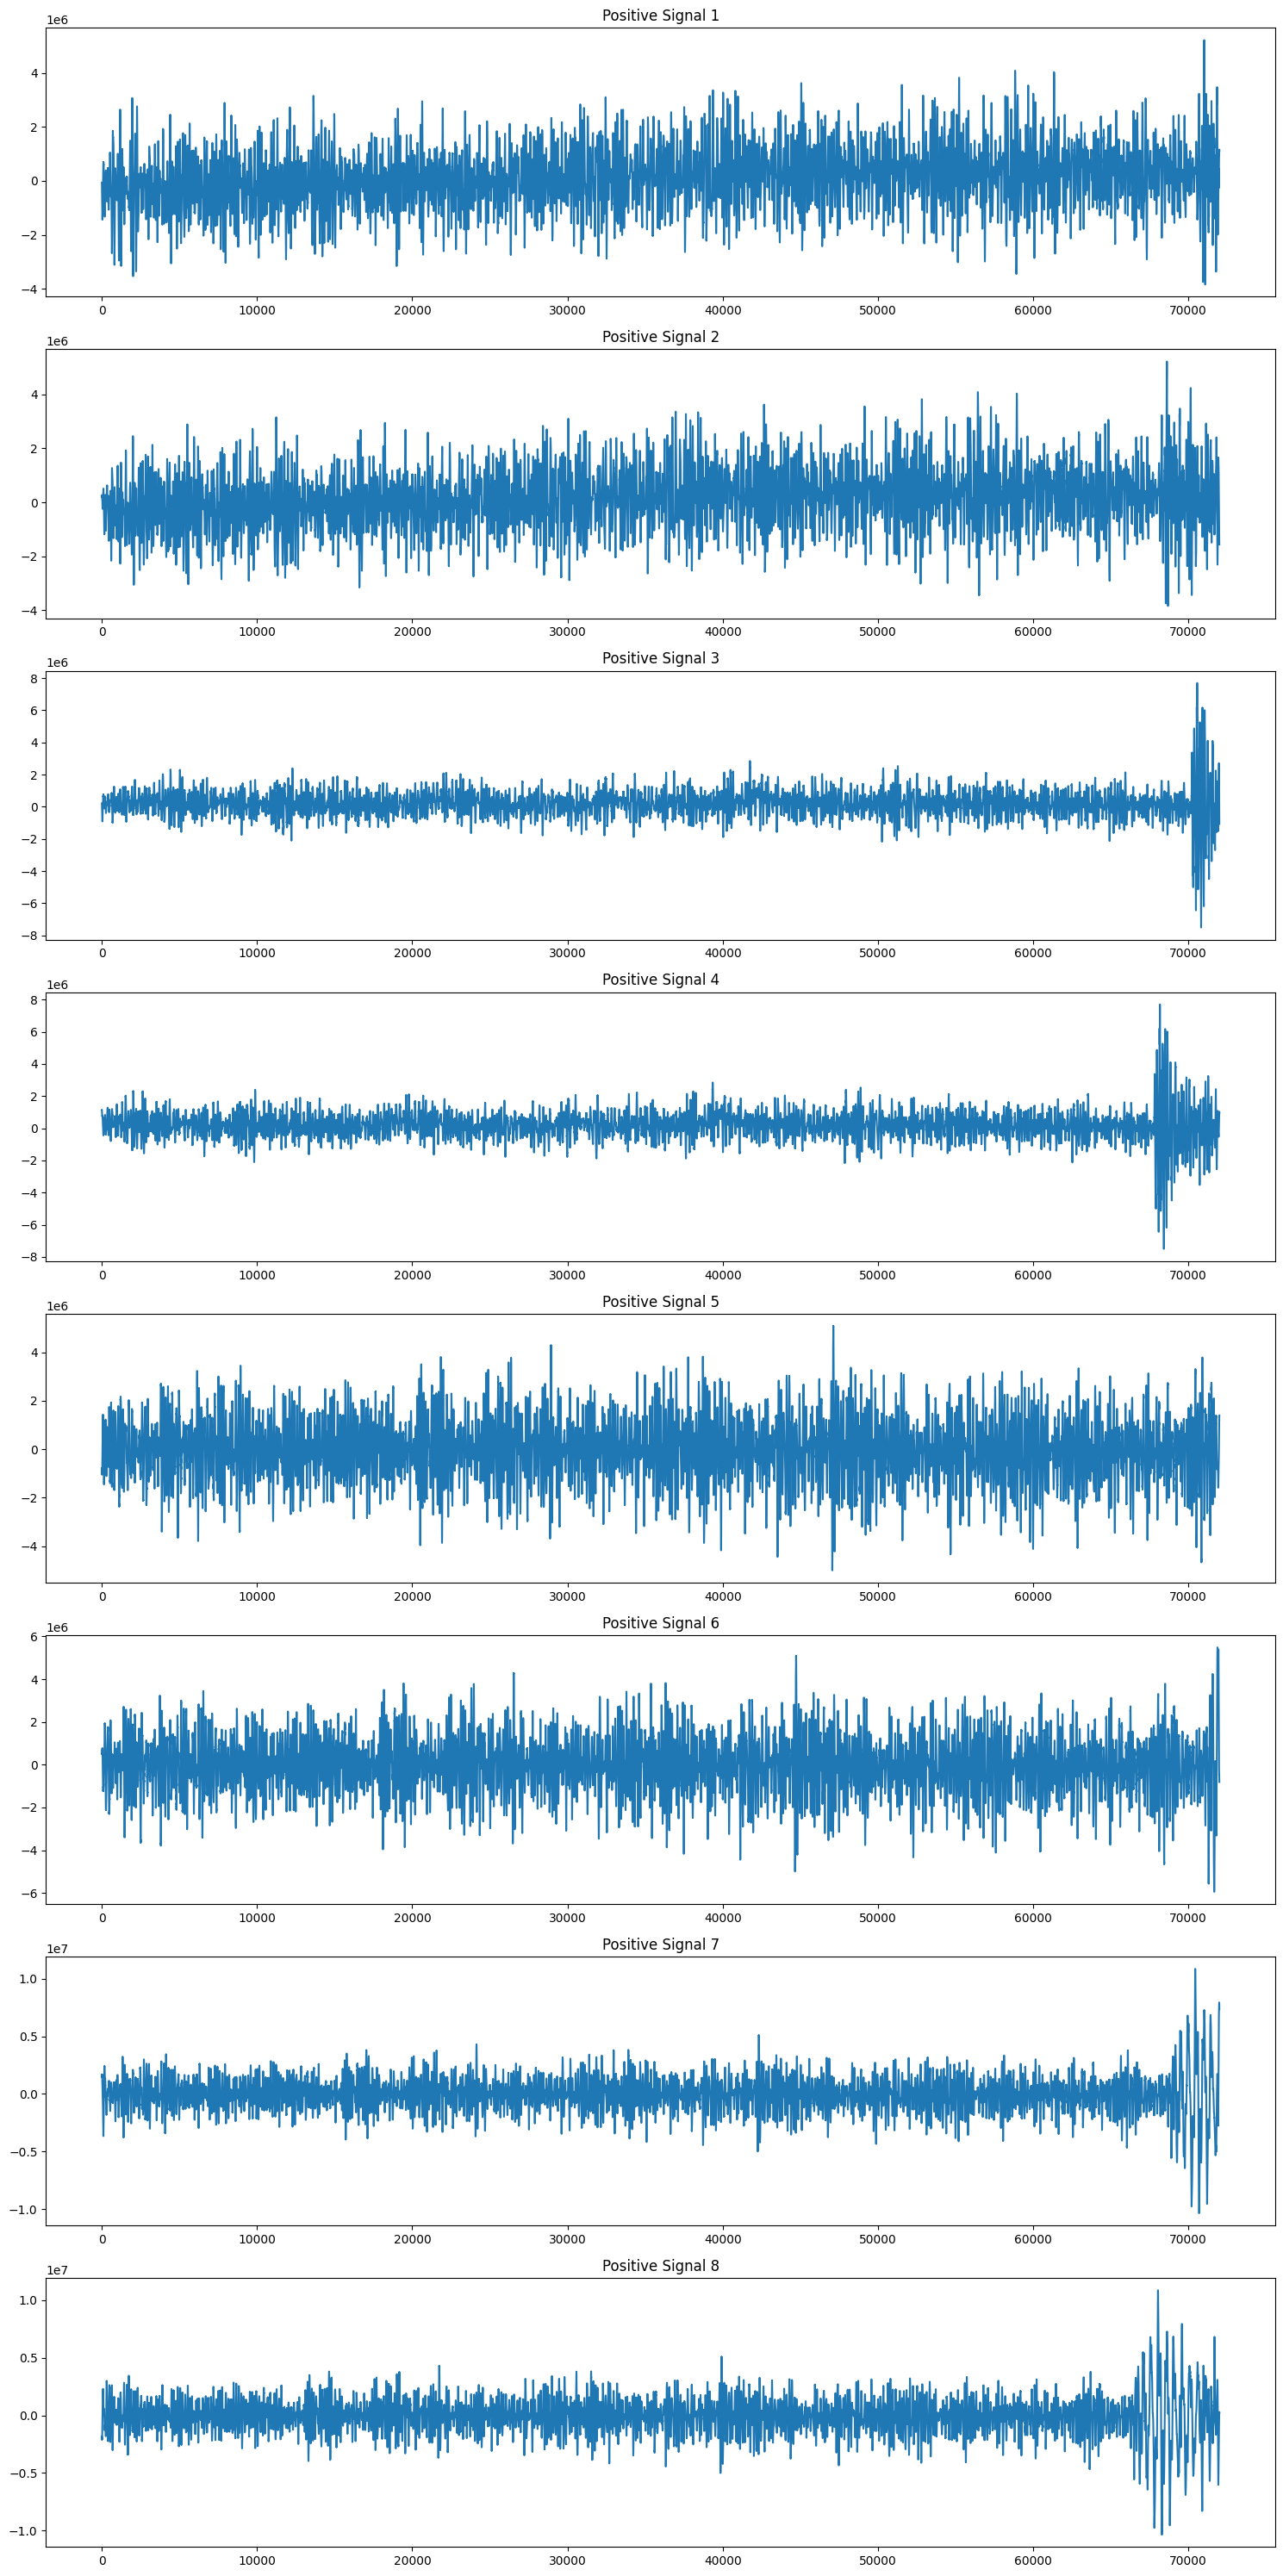

In [ ]:
# plot the first 8 arrays of positive_1800s_signals

fig, axes = plt.subplots(8, 1, figsize=(15, 30))

for i in range(8):
    y = positive_1800s_signals[i]
    axes[i].plot(y)
    axes[i].set_title(f'Positive Signal {i+1}')

plt.tight_layout()
plt.show()

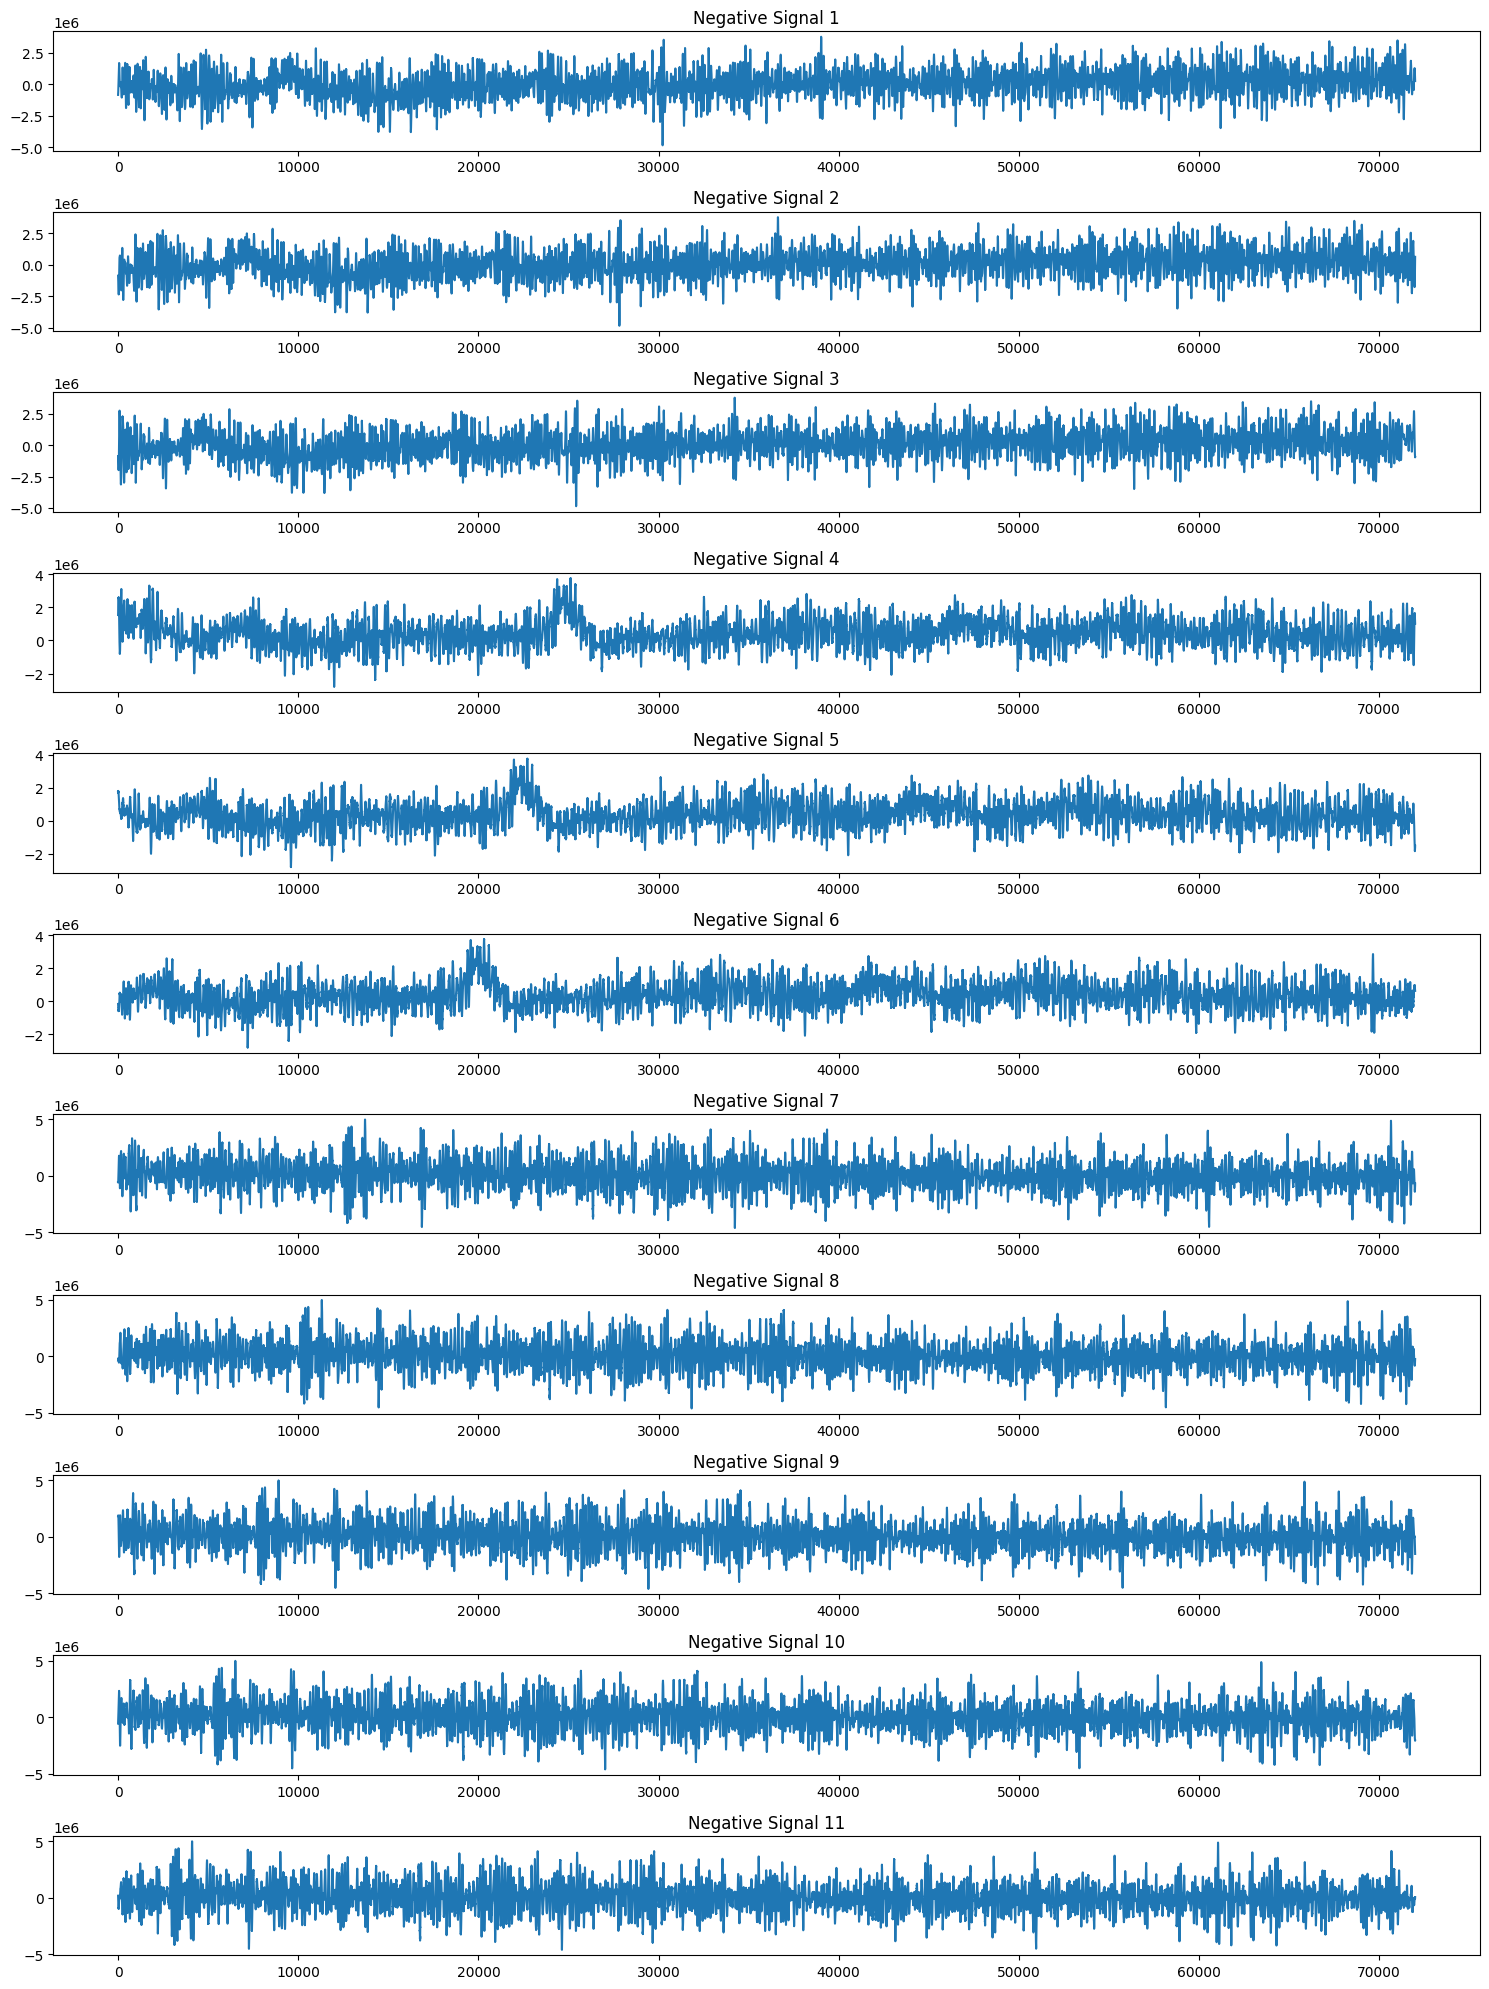

In [ ]:
# prompt: plot the first 11 signals of negative_signals

fig, axes = plt.subplots(11, 1, figsize=(15, 20))

for i in range(11):
    y = negative_1800s_signals[i]
    axes[i].plot(y)
    axes[i].set_title(f'Negative Signal {i+1}')

plt.tight_layout()
plt.show()